# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

__Udacity briefing__:

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.


---

## Contents

1.  <a href='#sagemaker_setup'>Sagemaker Setuip</a>  
1.  <a href='#load_data'>Load data</a>    
1.  <a href='#clean_data'>Clean data</a>
1.  <a href='#data_preparation'>Model data preparation</a>
1.  <a href='#baseline'>Setting a baseline</a>
1.  <a href='#training'>Sagemaker hyperparameter tuning</a>
1.  <a href='#predict'>Predict and feature analysis using validation dataset</a>
1.  <a href='#kaggle'>Kaggle competition - Final prediction on testing dataset</a>

---

In [2]:
# import libraries 
import os
import time

import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

# to analyze xgboost results locally
import graphviz
import tarfile
# for creating a feature tree
from xgboost import plot_tree
# for calculating feature importance
from xgboost import plot_importance

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Import custom modules
from src.config import *
from src.data_cleansing import *
from src.data_loading import *
from src.helper import *
from src.visuals import *

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_colwidth', 400)
pd.set_option('expand_frame_repr', True)

# magic word for producing visualizations in notebook
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [1]:
random_state = 88 

<a id='sagemaker_setup'></a>
# Step 1: Sagemaker Set-up

In [ ]:
# create sagemaker session
sagemaker_session = sagemaker.Session()

# assign sagemaker role
# detect if notebook is running locally or in a cluster
a=os.popen('hostname').read()
if 'local' in a:
    print('Notebook is running locally')
    role = sagemaker_role 
else:
    role = sagemaker.get_execution_role()
    print('Notebook is running on a cluster')

# set default bucket
bucket = sagemaker_session.default_bucket()
print('Bucket: {}'.format(bucket))

region = sagemaker_session.boto_region_name
print('Region: {}'.format(region))

output_path = 's3://{}/{}/output'.format(bucket, prefix)
print('S3 Output path: {}'.format(output_path))

# pointers to location of training, validation and testing datasets
s3_path_train = 's3://{}/{}/{}'.format(bucket, prefix, path_train[3:])
print('S3 Training path: {}'.format(s3_path_train))

s3_path_validation = 's3://{}/{}/{}'.format(bucket, prefix, path_validation[3:])
print('S3 Validation path: {}'.format(s3_path_validation))

s3_path_test = 's3://{}/{}/{}'.format(bucket, prefix, path_test[3:])
print('S3 Testing path: {}'.format(s3_path_test))

<a id='load_data'></a>
# Step 2: Load data

### Step 2.1 Load mailout training data

In [5]:
path = "{}/{}".format(path_raw, filename_mailout_train)
mailout_train, mailout_train_extended_na = get_data(path)
print('Shape of mailout TEST: {}'.format(mailout_train.shape))

Shape of mailout TEST: (42962, 366)


In [6]:
mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

### Step 2.2 Load mailout testing data
Outcome of which cluster each customer belongs to, can be re-used during supervised prediction

Further more, features dropped during clustering due it's absence in population data, might now be useful

In [7]:
path = "{}/{}".format(path_raw, filename_mailout_test)
mailout_test, mailout_test_extended_na = get_data(path)
print('Shape of mailout TRAIN: {}'.format(mailout_test.shape))

Shape of mailout TRAIN: (42833, 365)


In [8]:
mailout_test.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

### Step 2.3 Load customer segmenationation results from PART 2
Outcome of which cluster each customer belongs to, can be re-used during supervised prediction

Further more, features dropped during clustering due it's absence in population data, might now be useful

In [9]:
# Get customers clusters and pca features from step 2
customer_clusters = pd.read_csv(filename_customer_clusters, index_col=0)
print('Shape of mailout TRAIN: {}'.format(customer_clusters.shape))

Shape of mailout TRAIN: (191652, 183)


In [10]:
# compare to step 2, we don't want any rows dropped we expect 191652 rows
customer_clusters.shape

(191652, 183)

<a id='clean_data'></a>
# Step 3: Clean Data

### Step 3.1 Clean training and testing dataset using standard cleaning function

In [11]:
# keep a copy of the raw data before we change it
mailout_train_raw = mailout_train.copy()

In [12]:
# seperate data and labels
mailout_train_response = pd.DataFrame(mailout_train['RESPONSE'], 
                                      columns=['RESPONSE'])
mailout_train.drop('RESPONSE', axis=1, inplace=True, errors='ignore')
mailout_train_response.head()

,RESPONSE
LNR,
1763,0
1771,0
1776,0
1460,0
1783,0


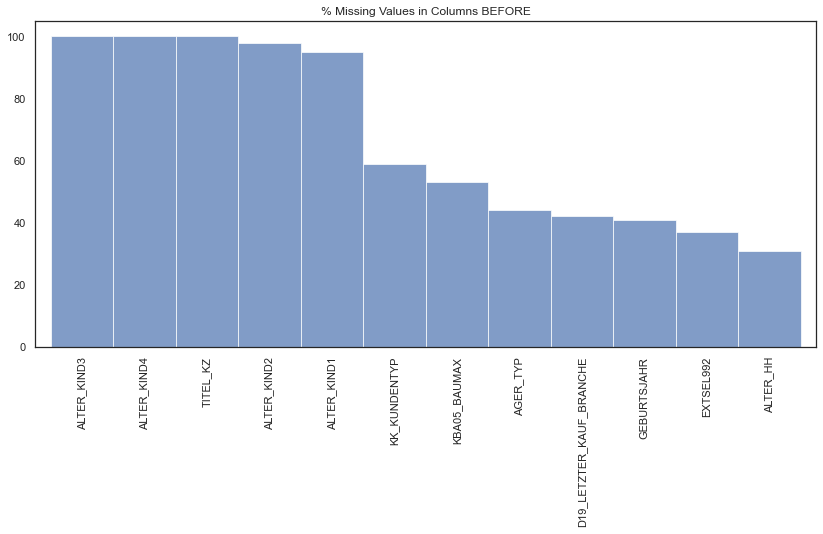

Summarize GRID columns.....
Binarize GRID columns.....

Columns dropped due to missing values ['EXTSEL992', 'D19_TELKO_MOBILE', 'D19_SCHUHE', 'D19_VERSAND_REST', 'AGER_TYP', 'TITEL_KZ', 'D19_HAUS_DEKO', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_RATGEBER', 'D19_BEKLEIDUNG_GEH', 'CAMEO_DEU_2015', 'D19_TELKO_ONLINE_QUOTE_12', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_GROSS', 'KK_KUNDENTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'D19_FREIZEIT']


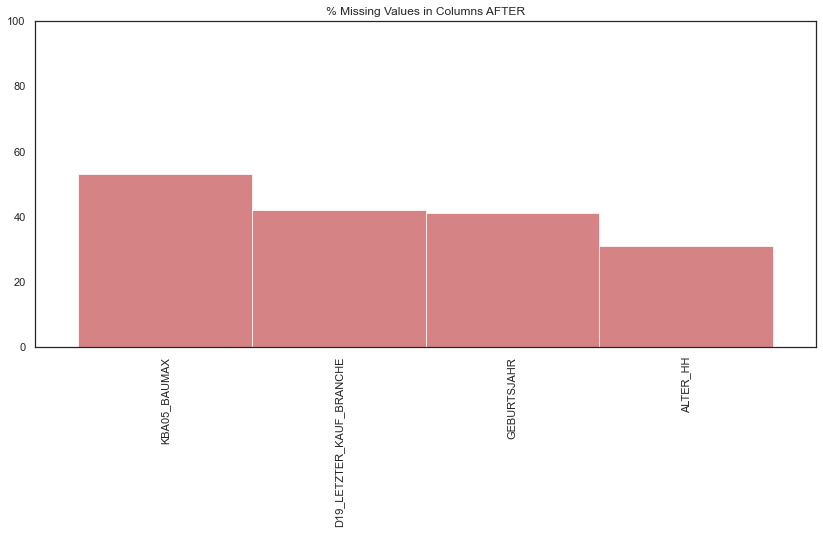

Shape BEFORE row deletion: (42962, 348)


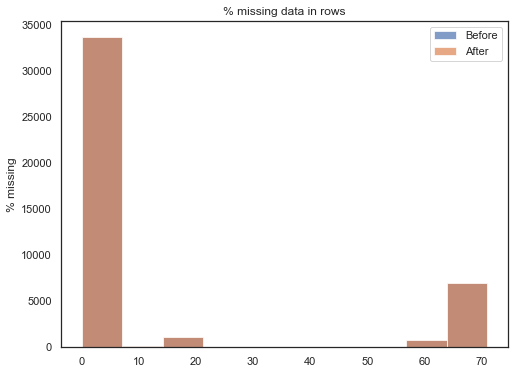

Shape AFTER row deletion: (42962, 348) with threshold of: 1
Adding few features WOHNLAGE_QUALITY and WOHNLAGE_RURAL ..........
Adding few features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT ..........
Adding few features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE ..........
Cleaning PLZ8_BAUMAX, KBA05_BAUMAX .......... 
Cleaning OST_WEST_KZ .......... 
Reducing range for D19_KONSUMTYP_MAX from 1-8 to 1-5
Reducing range for D19_KONSUMTYP from 1-9 to 1-7
Rerank ranges for banking transactions
Categorial columns to one hot encode: ['D19_LETZTER_KAUF_BRANCHE']
353 total features BEFORE one-hot encoding
386 total features AFTER one-hot encoding
[IterativeImputer] Completing matrix with shape (42962, 386)
[IterativeImputer] Ending imputation round 1/15, elapsed time 2.57
[IterativeImputer] Ending imputation round 2/15, elapsed time 4.89
[IterativeImputer] Ending imputation round 3/15, elapsed time 7.04
[IterativeImputer] Ending imputation round 4/15, elapsed ti

In [13]:
mailout_train_cleaned = clean(mailout_train.copy(), 
                              mailout_train_extended_na, 
                              rows_threshold=1, 
                              impute=True,
                              kind='supervised')

In [14]:
mailout_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 1763 to 69224
Columns: 420 entries, AKT_DAT_KL to GRID_YEAR_LAST_ACTIVE_2
dtypes: float64(1), int16(315), uint8(104)
memory usage: 30.7 MB


### Step 3.2 Clean testing dataset using standard cleaning function

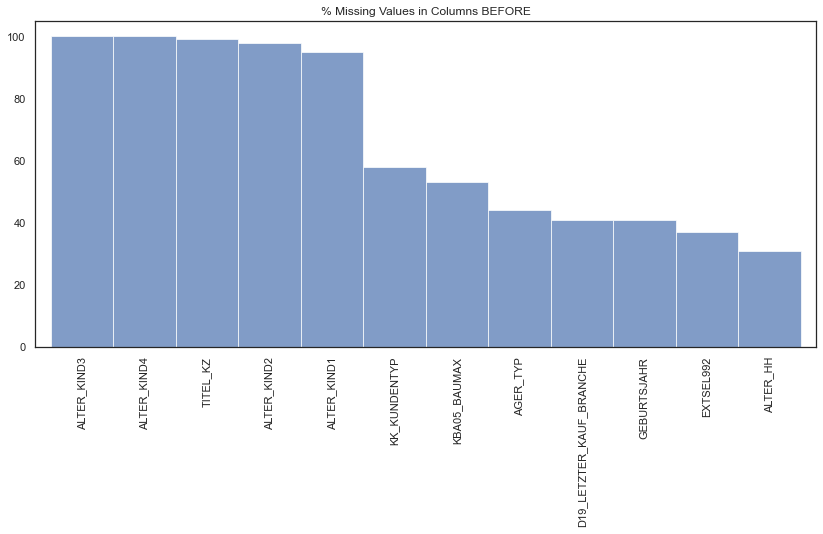

Summarize GRID columns.....
Binarize GRID columns.....

Columns dropped due to missing values ['EXTSEL992', 'D19_TELKO_MOBILE', 'D19_SCHUHE', 'D19_VERSAND_REST', 'AGER_TYP', 'TITEL_KZ', 'D19_HAUS_DEKO', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_RATGEBER', 'D19_BEKLEIDUNG_GEH', 'CAMEO_DEU_2015', 'D19_TELKO_ONLINE_QUOTE_12', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_GROSS', 'KK_KUNDENTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'D19_FREIZEIT']


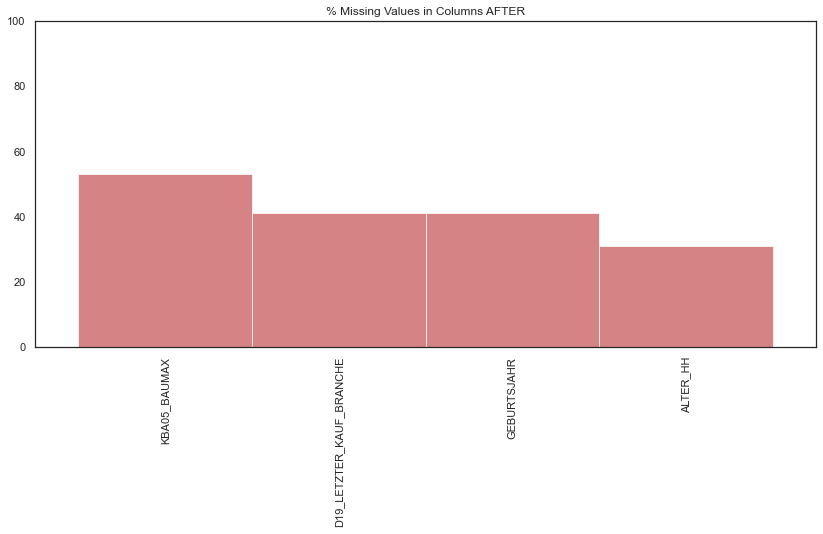

Shape BEFORE row deletion: (42833, 348)


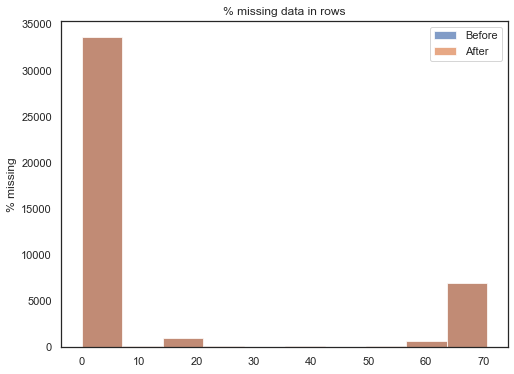

Shape AFTER row deletion: (42833, 348) with threshold of: 1
Adding few features WOHNLAGE_QUALITY and WOHNLAGE_RURAL ..........
Adding few features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT ..........
Adding few features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE ..........
Cleaning PLZ8_BAUMAX, KBA05_BAUMAX .......... 
Cleaning OST_WEST_KZ .......... 
Reducing range for D19_KONSUMTYP_MAX from 1-8 to 1-5
Reducing range for D19_KONSUMTYP from 1-9 to 1-7
Rerank ranges for banking transactions
Categorial columns to one hot encode: ['D19_LETZTER_KAUF_BRANCHE']
353 total features BEFORE one-hot encoding
386 total features AFTER one-hot encoding
[IterativeImputer] Completing matrix with shape (42833, 386)
[IterativeImputer] Ending imputation round 1/15, elapsed time 2.84
[IterativeImputer] Ending imputation round 2/15, elapsed time 5.78
[IterativeImputer] Ending imputation round 3/15, elapsed time 8.82
[IterativeImputer] Ending imputation round 4/15, elapsed ti

In [15]:
# for the final submission to kaggle, do not drop any rows as all rows required by Kaggle
mailout_test_cleaned = clean(mailout_test.copy(), 
                             mailout_test_extended_na, 
                             rows_threshold=1, 
                             impute=True,
                             kind='supervised')

In [16]:
mailout_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 1754 to 68898
Columns: 420 entries, AKT_DAT_KL to GRID_YEAR_LAST_ACTIVE_2
dtypes: float64(1), int16(315), uint8(104)
memory usage: 30.6 MB


### Step 3.3 - Scale
A scalar was build using the full population dataset excluding all missing values
This helps to better generalize the data to unseen data during testing

In [17]:
# Load the pre-trained scalar 
scaler = load(open(filename_scaler_supervised, 'rb'))

In [18]:
# Correct TRAINING dataset
# check if there are any columns missing in customers dataset due to ohn. 
# MinMax scaling requires in latest version the same number of features in the same order
cols = list(set(scaler.feature_names_in_) - set(mailout_train_cleaned.columns))  
scaler_features = list(scaler.feature_names_in_)
for col in cols:
    print('Column corrected: {}'.format(col))
    loc =  scaler_features.index(col)
    mailout_train_cleaned.insert(loc, column=col, value=0)   

Column corrected: GEBAEUDETYP_5


In [19]:
# Correct TESTING dataset
# check if there are any columns missing in customers dataset due to ohn. 
# MinMax scaling requires in latest version the same number of features in the same order
cols = list(set(scaler.feature_names_in_) - set(mailout_test_cleaned.columns))  
scaler_features = list(scaler.feature_names_in_)
for col in cols:
    print('Column corrected: {}'.format(col))
    loc =  scaler_features.index(col)
    mailout_test_cleaned.insert(loc, column=col, value=0)   

Column corrected: GEBAEUDETYP_5


In [20]:
# Scale training data
scaled_mailout_train = scaler.transform(mailout_train_cleaned.copy())


# Rebuild dataframe
df_scaled_mailout_train = pd.DataFrame(scaled_mailout_train, 
                                       columns=mailout_train_cleaned.columns, 
                                       index=mailout_train_cleaned.index)

df_scaled_mailout_train.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_REISEN,D19_SAMMELARTIKEL,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,...,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,WOHNLAGE_QUALITY,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS,KBA05_BAUMAX_BUSINESS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BR

In [21]:
# Scale testing data
scaled_mailout_test = scaler.transform(mailout_test_cleaned.copy())

# Rebuild dataframe
df_scaled_mailout_test = pd.DataFrame(scaled_mailout_test, 
                                    columns=mailout_test_cleaned.columns, 
                                    index=mailout_test_cleaned.index).round(4)
df_scaled_mailout_test.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_REISEN,D19_SAMMELARTIKEL,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,...,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,WOHNLAGE_QUALITY,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS,KBA05_BAUMAX_BUSINESS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BR

In [22]:
# include clustering results and additional customer data

col = ['CLUSTER', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

df_cluster_label_scaled = customer_clusters[col].copy()
df_cluster_label_scaled = ohn(df_cluster_label_scaled, ['CLUSTER', 'PRODUCT_GROUP']) 

df_cluster_label_scaled.head()

3 total features BEFORE one-hot encoding
12 total features AFTER one-hot encoding


,ONLINE_PURCHASE,CLUSTER_0,CLUSTER_1,CLUSTER_2,CLUSTER_3,CLUSTER_4,CLUSTER_5,CLUSTER_6,CLUSTER_7,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD
LNR,,,,,,,,,,,,
9626,0,1,0,0,0,0,0,0,0,0,1,0
9628,0,0,0,0,1,0,0,0,0,0,0,1
143872,0,1,0,0,0,0,0,0,0,0,1,0
143873,0,0,0,0,1,0,0,0,0,1,0,0
143874,0,0,0,0,0,0,1,0,0,0,0,1


### Step 3.4 - Merge clustering and mailout data

In [23]:
# keep mailout columns with only selected fields from clustering
def clustering_merge(df1, df2, join_type='left'):
    mailout_enriched = df1.merge(df2, how=join_type, left_index=True, right_index=True, indicator=True)
    if (mailout_enriched['_merge'] != 'both').sum() > 0:
        print('Error something went wrong - not all customers have clusters ?')
        mailout_enriched.drop(['_merge'], inplace=True, axis=1)
    else:
        mailout_enriched.drop(['_merge'], inplace=True, axis=1)   
           
    return mailout_enriched

In [24]:
# # keep only pca and cluster columns but filter on index
# def clustering_filter(df1, df2, join_type='left'):
#     mailout_enriched = df1.merge(df2, how=join_type, left_index=True, right_index=True, indicator=True)
#     mailout_enriched = mailout_enriched[mailout_enriched['_merge'] == 'both'].iloc[:,:df1.shape[1]]            
#     return mailout_enriched

In [25]:
# # use pca fields
# df_scaled_mailout_train_enriched = clustering_filter(customer_clusters, 
#                                                     df_scaled_mailout_train, 
#                                                     join_type="left")


# df_scaled_mailout_train_enriched = ohn(df_scaled_mailout_train_enriched, ['CLUSTER']) 

# print('Shape of mailout dataset {} vs PCA dataset {}'.format(df_scaled_mailout_train.shape, 
#                                                              df_scaled_mailout_train_enriched.shape))
# df_scaled_mailout_train_enriched.sort_index().head()

In [26]:
# df_scaled_mailout_test_enriched = clustering_filter(customer_clusters, 
#                                                     df_scaled_mailout_test, 
#                                                     join_type="left")
# print('Shape of mailout dataset {} vs PCA dataset {}'.format(df_scaled_mailout_test.shape, 
#                                                              df_scaled_mailout_test_enriched.shape))
# df_scaled_mailout_test_enriched.sort_index().head()

In [27]:
df_scaled_mailout_train_enriched = clustering_merge(df_scaled_mailout_train, df_cluster_label_scaled)
df_scaled_mailout_train_enriched.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_REISEN,D19_SAMMELARTIKEL,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,...,KONSUMZELLE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,WOHNLAGE_QUALITY,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS,KBA05_BAUMAX_BUSINESS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19

In [28]:
df_scaled_mailout_train.shape

(42962, 421)

In [29]:
df_scaled_mailout_test_enriched = clustering_merge(df_scaled_mailout_test, df_cluster_label_scaled)
df_scaled_mailout_test_enriched.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_REISEN,D19_SAMMELARTIKEL,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,...,KONSUMZELLE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,WOHNLAGE_QUALITY,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS,KBA05_BAUMAX_BUSINESS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19

### Step 3.5 - Any final columns to drop ?

In [30]:
columns_to_drop = []
columns_to_drop

[]

In [31]:
print('Before: {}'.format(df_scaled_mailout_train_enriched.shape))
df_scaled_mailout_train_enriched.drop(columns_to_drop, inplace=True, axis=1, errors='ignore')
print('After: {}'.format(df_scaled_mailout_train_enriched.shape))

Before: (42962, 433)
After: (42962, 433)


In [32]:
print('Before: {}'.format(df_scaled_mailout_test_enriched.shape))
df_scaled_mailout_test_enriched.drop(columns_to_drop, inplace=True, axis=1, errors='ignore')
print('After: {}'.format(df_scaled_mailout_test_enriched.shape))

Before: (42833, 433)
After: (42833, 433)


### Step 3.6 - Final Data Explorations

###### Do we see a pattern if mainly individuals from certain clusters respond ?

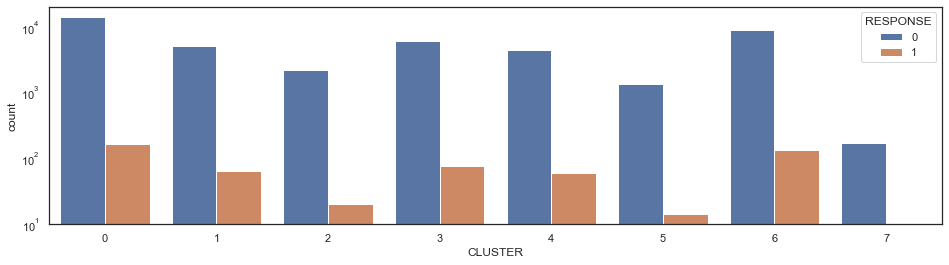

In [33]:
cluster_label = customer_clusters[['CLUSTER']].copy()
response_clusters = mailout_train_response.merge(cluster_label, how='left', left_index=True, right_index=True)
response_clusters['CLUSTER'].value_counts()

fig, ax = plt.subplots(figsize=(16,4))
plt.yscale('log')
sns.countplot(x='CLUSTER', data=response_clusters, ax=ax, hue='RESPONSE')  
plt.show()

In [34]:
response_clusters 

,RESPONSE,CLUSTER
LNR,,
1763,0,3
1771,0,0
1776,0,0
1460,0,3
1783,0,3
...,...,...
66338,0,2
67629,0,0
68273,0,0


**Conclusion:** 
When combining clustering with the mail-out campaign results from the provided training dataset, we can observe that no individuals from cluster 7 responded to the campaign, and the most individuals from cluster 0 and 6 responded. This fits with our previous analysis where cluster 7 where the most under represented and cluster 0 where the most over represented.

<a id='data_preparation'></a>
# Step 4: Model data preparation

In [35]:
# sort datasets
df_scaled_mailout_train_enriched.sort_index(inplace=True)
mailout_train_response.sort_index(inplace=True)

In [36]:
# Analyzing the rows we are dropping

In [37]:
mailout_train_response.shape

(42962, 1)

In [38]:
df_scaled_mailout_train_enriched.shape

(42962, 433)

In [39]:
# get responses for those records we intent to drop
test_drop = mailout_train_response[~mailout_train_response.index.isin(df_scaled_mailout_train_enriched.index)]
test_drop = test_drop[test_drop['RESPONSE'] == 1]
test_drop.shape

(0, 1)

In [40]:
test_nodrop = mailout_train_response[~mailout_train_response.index.isin(df_scaled_mailout_train_enriched.index)]
# test_nodrop = test_nodrop[test_nodrop['RESPONSE'] == 1]
test_nodrop.shape

(0, 1)

In [41]:
final_nodrop = mailout_train_raw[mailout_train_raw.index.isin(test_nodrop.index)]
final_nodrop.describe()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13

In [42]:
final_drop = mailout_train_raw[mailout_train_raw.index.isin(test_drop.index)]
final_drop

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [43]:
# filter response dataset with rows we dropped
mailout_train_response = mailout_train_response[mailout_train_response.index.isin(df_scaled_mailout_train_enriched.index)]

# Define the resampling method
# resample = SMOTE(k_neighbors=50, random_state=random_state, n_jobs=-1)
# resample = ADASYN(n_neighbors=50, random_state=random_state, n_jobs=-1)
resample = RandomOverSampler(sampling_strategy='minority', random_state=random_state)

# Split the 'features' and 'income' data into training and valiation datasets
X_train, X_validate, y_train, y_validate = train_test_split(df_scaled_mailout_train_enriched, 
                                                    mailout_train_response,
                                                    stratify=mailout_train_response['RESPONSE'],
                                                    test_size = 0.3, 
                                                    random_state = random_state)

X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

# Show the results of the split
print("Training dataset has {} samples.".format(X_train.shape[0]))
print("Validation dataset has {} samples.".format(X_validate.shape[0]))
print("Resampled Training dataset has {} samples.".format(X_resampled.shape[0]))

Training dataset has 30073 samples.
Validation dataset has 12889 samples.
Resampled Training dataset has 59402 samples.


In [44]:
# Count the occurrences of responded vs not responded in the training dataset
occ = y_train['RESPONSE'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / len(y_train.index))

0    29701
1      372
Name: RESPONSE, dtype: int64
0    0.98763
1    0.01237
Name: RESPONSE, dtype: float64


In [45]:
# ratio of negative responses / positive responses
scale_pos_weight = occ[0]/occ[1]
scale_pos_weight

79.84139784946237

In [46]:
# Count the occurrences of responded vs not responded in the training dataset
occ = y_validate['RESPONSE'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / len(y_validate.index))

0    12729
1      160
Name: RESPONSE, dtype: int64
0    0.987586
1    0.012414
Name: RESPONSE, dtype: float64


In [47]:
# Count the occurrences of responded vs not responded in the RESAMPLED training dataset
occ = y_resampled['RESPONSE'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / len(y_resampled.index))

0    29701
1    29701
Name: RESPONSE, dtype: int64
0    0.5
1    0.5
Name: RESPONSE, dtype: float64


---
## Save training and testing data in S3

Now, we are almost ready to move on to training a model in SageMaker!

We want to access the train and test data in SageMaker and upload it to S3. In this project, SageMaker will expect the following format for your train/test data:
* Training and test data should be saved in one `.csv` file each, ex `train.csv` and `test.csv`
* These files should have class  labels in the first column and features in the rest of the columns

This format follows the practice, outlined in the [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html), which reads: "Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable [class label] is in the first column."

### Create csv files


In [48]:
train_location, df = make_train_csv(x=X_resampled.copy(), 
                                    y=y_resampled.copy(), 
                                    prefix=prefix, 
                                    local_path=path_train, 
                                    filename=filename_train_csv,
                                    sagemaker_session=sagemaker_session,
                                    bucket=bucket)
df.head()

Local path: ../data/train/train/train.csv with shape (59402, 433)
File created: s3://sagemaker-eu-west-1-554017193854/arvato_customer_segmentation/../data/train/train/train.csv


,RESPONSE,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_REISEN,D19_SAMMELARTIKEL,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,...,KONSUMZELLE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,WOHNLAGE_QUALITY,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS,KBA05_BAUMAX_BUSINESS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19_LETZT

In [49]:
validation_location, df = make_train_csv(x=X_validate.copy(), 
                                         y=y_validate.copy(), 
                                         prefix=prefix, 
                                         local_path=path_validation, 
                                         filename=filename_validation_csv,
                                         sagemaker_session=sagemaker_session,
                                         bucket=bucket)                                         
df.head()

Local path: ../data/train/validation/validation.csv with shape (12889, 433)
File created: s3://sagemaker-eu-west-1-554017193854/arvato_customer_segmentation/../data/train/validation/validation.csv


,RESPONSE,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_REISEN,D19_SAMMELARTIKEL,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,...,KONSUMZELLE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,WOHNLAGE_QUALITY,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS,KBA05_BAUMAX_BUSINESS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19_LETZT

In [50]:
test_location = make_test_csv(x=X_validate, 
                              prefix=prefix, 
                              local_path=path_validation_test, 
                              filename=filename_test_csv,
                              sagemaker_session=sagemaker_session,
                              bucket=bucket)

test_location

Local path: ../data/train/test/test.csv with shape (12889, 433)
File created: s3://sagemaker-eu-west-1-554017193854/arvato_customer_segmentation/../data/train/test/test.csv


's3://sagemaker-eu-west-1-554017193854/arvato_customer_segmentation/../data/train/test/test.csv'

In [51]:
# create a feature map for feature importance analysis
feature_names = list(X_validate.columns)
create_feature_map(feature_names)

<a id='baseline'></a>
# Step 5: Setting a baseline


As benchmark Sklear algorithms have been chosen which solve binary classification problems. Decision trees are easy to understand, train fast, but can easily overtrain. It fits well to the large dataset full of mostly categorical and ordinal features.

DecisionTreeClassifier, AdaBoostClassifier and XGBClassier was selected


In [50]:
# Initialize sklearn models

clf_A = DecisionTreeClassifier(random_state=random_state)


dt = DecisionTreeClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=5, class_weight='balanced')
clf_C = AdaBoostClassifier(clf_A,
                           n_estimators=100, 
                           random_state=random_state)

param = {
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'n_estimators': 100,
         'random_state': random_state
}

clf_D = xgb.XGBClassifier(use_label_encoder=False)
clf_D.set_params(**param)


# Collect results on the learners
results = {}

for clf in [clf_A, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, 
                                      X_resampled, np.array(y_resampled).reshape(len(y_resampled)), 
                                      X_validate, np.array(y_validate).reshape(len(y_validate)))

Start of training: DecisionTreeClassifier
DecisionTreeClassifier training completed
Start of training: AdaBoostClassifier
AdaBoostClassifier training completed
Start of training: XGBClassifier
XGBClassifier training completed


<AxesSubplot:title={'center':'AUC'}>

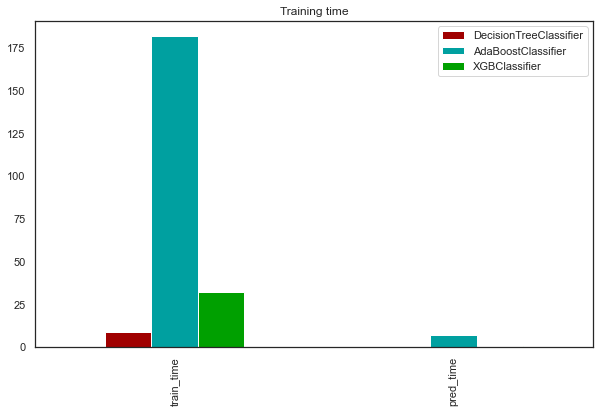

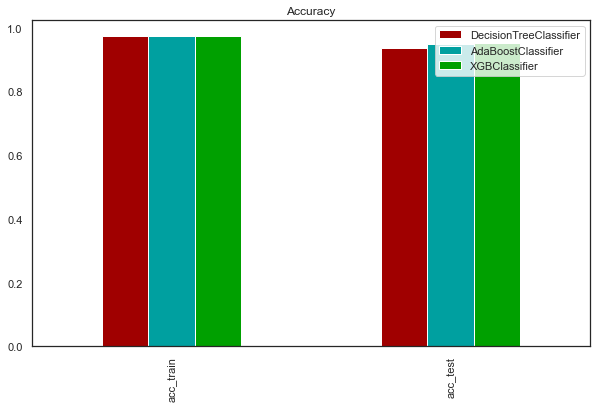

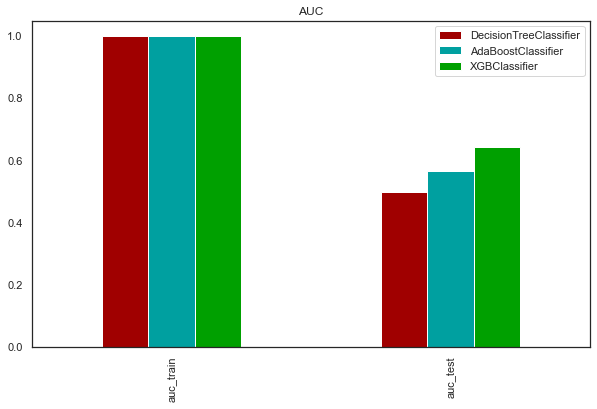

In [51]:
df = pd.DataFrame(results) 
color = ['#A00000','#00A0A0','#00A000']
figsize = (10,6)

df.loc[['train_time', 'pred_time']].plot(kind='bar',
                                         figsize=figsize,
                                         color=color,
                                         title='Training time')
           
df.loc[['acc_train', 'acc_test']].plot(kind='bar',
                           figsize=figsize,
                           color=color,
                           title='Accuracy')

df.loc[['auc_train', 'auc_test']].plot(kind='bar',
                           figsize=figsize,
                           color=color,
                           title='AUC')

In [52]:
results

{'DecisionTreeClassifier': {'train_time': 8.716790914535522,
  'pred_time': 0.1593458652496338,
  'acc_train': 0.9742264570216491,
  'acc_test': 0.9365350298704321,
  'auc_train': 0.9980770116738991,
  'auc_test': 0.4985358237096394},
 'AdaBoostClassifier': {'train_time': 181.7461519241333,
  'pred_time': 7.088213920593262,
  'acc_train': 0.9742264570216491,
  'acc_test': 0.9474745907362867,
  'auc_train': 0.998077011673899,
  'auc_test': 0.5633946107314007},
 'XGBClassifier': {'train_time': 32.39763784408569,
  'pred_time': 0.5026071071624756,
  'acc_train': 0.9725430120197973,
  'acc_test': 0.9519745519435178,
  'auc_train': 0.99787597543242,
  'auc_test': 0.6408452156493046}}

Without any hyper parameter tuning, we can see that XGBClassier performed better with 64% AUC on the validation dataset of 64%, which I will use as a benchmark.
We can also observe the AUC on the training dataset is 100% on all 3 algorithms, which indicates that the model is overfitting. Decision trees tends too easily overfit, we will have to constrain them using L1 and L2 regulation, tree depth and child_weight especially.

Below are the first attempt to observe the behaviour of XGBoost with manual parameter tuning, in order to set a good base and ranges for sagemaker's hyperparamater tuning in the next step

In [61]:
# load training and testing files from locally stored csv fiels and store in DMatrix format
# label_column specifies the index of the column containing the true label
dtrain = xgb.DMatrix(os.path.join(path_train, 'train.csv?format=csv&label_column=0'))
dtest = xgb.DMatrix(os.path.join(path_validation, 'validation.csv?format=csv&label_column=0'))

In [169]:
# set weight of all features to 0.5
# fw = np.full(shape=X_validate.shape[1], fill_value=0.5)
# fw

In [170]:
# set weight of class features to 1
# cols = list(X_validate.columns)
# cols_start = cols.index('CLUSTER_0')
# cols_end = cols_start + 7
# fw[cols_start:cols_end] = 2
# fw

In [ ]:
# hyper parameters to play around with
param = {
         'max_depth': 3, 
         'eta': 0.01,       
         'alpha': 320, # L1 regularization parameter
         'gamma': 10, 
         'min_child_weight': 10,
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
#        'scale_pos_weight': scale_pos_weight,
         'max_delta_step': 10,   
         'lambda': 10, # L2 regularization
         "min_child_weight": 10,
         "subsample": 0.80,
         "seed": random_state,
         "booster": "gbtree",
         "tree_method": 'exact', 
         "colsample_bytree": 0.7,
}

dtrain.set_info(feature_weights=fw)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 500

bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50)
ypred = bst.predict(dtest)

In [76]:
print('\nAUC: {}'.format(roc_auc_score(y_validate, ypred)))


AUC: 0.7596128918218242


<a id='training'></a>
# Step 6: Hyper Parameter XGBoost Training Sagemaker


Gradient boosting involves creating and adding trees to the model sequentially.

New trees are created to correct the residual errors in the predictions from the existing sequence of trees.
The effect is that the model can quickly fit, then overfit.

The hyperparameters that have the greatest effect on optimizing the XGBoost evaluation metrics are: 
- alpha, min_child_weight, subsample, eta, and num_round.

A technique to slow down the learning in the gradient boosting model is to apply a weighting factor for the corrections by new trees when added to the model. This weighting is called the shrinkage factor or the learning rate, depending on the literature or the tool.

Description of some parameters:
- alpha:L1 regularization parameter increasing this value makes model more conservative [0-1]
- lambda: L2 regularization parameter increasing this value makes model more conservative 
- booster: btree, gblinear, or dart
- eta: learning rate, parameter can be set to control the weighting of new trees added to the model. Smaller numbers avoid overfitting but then we need more trees/estimators  
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm is.

In [100]:
# initialize hyperparameters
hyperparameters = {
        "max_depth": 3,
        "eta": 0.01,   # learning rate                        
        "alpha": 340.91493342423814, # L1 regularization parameter
        "lambda": 12.053141402482922, # L2 regularization parameter
        "gamma": 16.140943570479283, 
        "min_child_weight": 15.036120500554022,
        "subsample": 0.8298039038786528,
        "objective": "binary:logistic",
        "early_stopping_rounds": 500,
        "num_round": 5000,
        "verbosity": 3,
        "seed": random_state,
        "booster": "gbtree",
        "tree_method": 'exact', 
        "max_delta_step": 10.67483920812812,
        "colsample_bytree": 0.8, 
            }
       
# generate diagnostics report
rules=[
    Rule.sagemaker(rule_configs.create_xgboost_report())
]

# create diagnostics report
save_interval = 30

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.3-1")

# construct a SageMaker estimator that calls the xgboost-container
xgb_model = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=100, # GB size
                                          output_path=output_path,
#                                           enable_categorical=True, 
                                          use_label_encoder=False, 
#                                           base_job_name="debugger-xgboost-report-demo",
                                          rules=rules,
                                         )


In [101]:
# Set hyperparameter ranges
hyperparameter_ranges = {
                        'eta': ContinuousParameter(0.1, 0.2),  
                        'min_child_weight': ContinuousParameter(8,20),
                        'max_depth': IntegerParameter(1, 3),
                        'alpha': ContinuousParameter(300, 400), 
                        'lambda': ContinuousParameter(8, 40), # L2
                        'gamma':ContinuousParameter(10, 40),  
                        'max_delta_step': ContinuousParameter(8, 20), 
                        'colsample_bytree': ContinuousParameter(0.6, 0.8),
                        }

# set the metric
objective_metric_name = 'validation:auc'

# Define hyper parameter job
xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb_model,
                                               objective_metric_name=objective_metric_name,
                                               objective_type='Maximize',
                                               hyperparameter_ranges=hyperparameter_ranges,
                                               max_jobs = 40,
                                               max_parallel_jobs = 5,
                                               early_stopping_type = 'Auto')

In [103]:
# Re-use learning from previous jobs
parent_tuning_job_name = {'sagemaker-xgboost-211213-1832', 
                          'sagemaker-xgboost-211214-0621', 
                          'sagemaker-xgboost-211214-0803'}

# warm_start_config = WarmStartConfig(
#     WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents=parent_tuning_job_name)

warm_start_config = WarmStartConfig(
    WarmStartTypes.TRANSFER_LEARNING, parents=parent_tuning_job_name)

xgb_hyperparameter_tuner = HyperparameterTuner(
    estimator=xgb_model,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type="Maximize",
    max_jobs=100,
    max_parallel_jobs=5,
#     base_tuning_job_name="warmstart",
    warm_start_config=warm_start_config,
    early_stopping_type = 'Auto'
)

In [ ]:
# define the data type and paths to the training and validation datasets in S3
# content_type = "application/x-parquet"
content_type = "text/csv"
train_input = TrainingInput(train_location, content_type=content_type, )
validation_input = TrainingInput(validation_location, content_type=content_type)

# execute the XGBoost training job
# xgb_model.fit({"train": train_input, "validation": validation_input}, wait=False)

# execute the XGBoost hyper paramater tuning job
xgb_hyperparameter_tuner.fit({"train": train_input, "validation": validation_input}, wait=True)

..................................................................................................................................................................................................................................................................

In [93]:
# tuning_job_name = xgb_hyperparameter_tuner.latest_tuning_job.job_name
# best_training_job = xgb_hyperparameter_tuner.best_training_job()

# to kick off an individual job
tuning_job_name = 'sagemaker-xgboost-211213-1832'
best_training_job = 'sagemaker-xgboost-211213-1832-069-dd8cf5cb'

# to kick off hyperparameter job
print('Hyper Parameter Tuning job: {}'.format(tuning_job_name))
print('Best Training job: {}'.format(best_training_job))

Hyper Parameter Tuning job: sagemaker-xgboost-211213-1832
Best Training job: sagemaker-xgboost-211213-1832-069-dd8cf5cb


<a id='predict'></a>
# Step 7. Predict and Feature Analysis using validation dataset

Load back a trained hyper parameter training job, and do predictions using the best performing model

In [171]:
def predict(tuningjobname, path_output, test_location, content_type='csv'):
    
    # get model info
    tuning_job_info = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuningjobname) 
    
    # Describe the results of the best training job. 
    best_training_job_name = tuning_job_info['BestTrainingJob']['TrainingJobName']
    training_job_info = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)
    model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']
    best_result = tuning_job_info['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']['Value']
    print('Best training job: {}'.format(best_training_job_name))
    print('Best_result: {}'.format(best_result))
    print('Model artifacts: {}'.format(model_artifacts))
     
    # Use the best model to predict  
    xgb_attached = sagemaker.estimator.Estimator.attach(best_training_job_name)
    xgb_attached.enable_sagemaker_metrics
    xgb_transformer = xgb_attached.transformer(instance_count = 1, 
                                               instance_type = 'ml.m5.4xlarge')
    
    xgb_transformer.transform(test_location, content_type=content_type, split_type='Line', wait=True)
    
    # copy the model prediction from S3 to local environment for easier further analysis
    !aws s3 cp --recursive $xgb_transformer.output_path $path_output
    
    print('Prediction output downloaded from {} to {}'.format(xgb_transformer.output_path, path_output))
    
    return xgb_transformer, model_artifacts

In [ ]:
# Predict validation dataset
xgb_transformer, model_artifacts = predict(tuning_job_name, path_output, test_location, content_type='csv')

In [173]:
def evaluate(path_output, y):
       
    # get predictions
    y_pred = pd.read_csv(os.path.join(path_output, 'test.csv.out'), header=None) 
    
    # round probability predictions to calculate the accuracy
    predictions = [round(num) for num in y_pred.squeeze().values]
    print('Accuracy: {}'.format(accuracy_score(y_validate.reset_index(drop=True), predictions)))
    
    # print confusion metrix
    print('\nConfusion matrix : \n{}'.format(confusion_matrix(y_validate, predictions)))
    
    # ROC needs that we pass the probability
    # https://stackoverflow.com/questions/62192616/strange-behavior-of-roc-auc-score-roc-auc-auc
    print('\nAUC: {}'.format(roc_auc_score(y, y_pred)))

In [174]:
# Test using validation dataset to see if we get the same AUC as AWS 
evaluate(path_output, y_validate)

Accuracy: 0.7160369307161145

Confusion matrix : 
[[9113 3616]
 [  44  116]]

AUC: 0.7738981852462881


In [ ]:
# Try to generate a xgboost report for the best performing job
xgb_attached = sagemaker.estimator.Estimator.attach(best_training_job)
xgb_attached.enable_sagemaker_metrics
xgb_transformer = xgb_attached.transformer(instance_count = 1, 
                                           instance_type = 'ml.m5.4xlarge')

xgb_transformer.transform(test_location, content_type=content_type, split_type='Line', wait=False)

### Feature and Tree analysis

In [ ]:
# copy the model locally to the notebook
!aws s3 cp $model_artifacts '../data/models/'

t = tarfile.open('../data/models/model.tar.gz', 'r:gz')
t.extractall(path='../data/models/')

# # Initialize and load the model
model = xgb.Booster()  
model.load_model('../data/models/xgboost-model')

In [ ]:
# plot xgboost feature importance      
xgb_feature_importance(xgb, model)

In [ ]:
# visualize the first tree
visualize_tree(xgb, bst, tree_to_plot=0)

In [ ]:
# Analyze tree complexity
trees = model.trees_to_dataframe(fmap=filename_model_featuremap)
trees_reduced = trees[trees['Feature'] != 'Leaf']
print('Maximum trees = {}'.format(max(trees_reduced['Tree'])))
print('Avg Depth = {}'.format(max(trees_reduced['Node'])))

In [ ]:
# get total gain by feature
features = trees.groupby('Feature')['Gain'].sum().sort_values(ascending=False)
features[:20].plot(kind='bar',figsize=(30,10))
plt.title('Feature importance - total gain')
plt.ylabel('F score')
plt.show()

<a id='kaggle'></a>
# Step 8: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# Override the test file in S3 with testing dataset
final_test_location = make_test_csv(df_scaled_mailout_test_enriched, 
                                    prefix, path_test, 
                                    filename_test_csv,
                                    sagemaker_session,
                                    bucket)

### Run Batch transform job

In [ ]:
path = "{}/test".format(path_output)
xgb_transformer_test, model_artifacts_test = predict(tuning_job_name, path_output, final_test_location) 

In [163]:
# get predictions
path = os.path.join(path_output, 'test.csv.out')
print(path)
y_pred = pd.read_csv(path, header=None, names=['RESPONSE'])


y_pred['LNR'] = df_scaled_mailout_test.index

y_pred

# change columns order
column_order = ['LNR', 'RESPONSE']
kaggle_output = y_pred.reindex(columns=column_order)

kaggle_output

../data/output/test.csv.out


,LNR,RESPONSE
0,1754,0.790247
1,1770,0.716811
2,1465,0.123594
3,1470,0.104463
4,1478,0.172217
...,...,...
42828,67615,0.463539
42829,67938,0.153994
42830,67942,0.534534
42831,67949,0.631884


In [164]:
# final output should have 42833 records
predictions = [round(num) for num in y_pred['RESPONSE'].squeeze().values]
print('Prediction response {} out of {}'.format(sum(predictions), len(predictions)))

Prediction response 12526 out of 42833


In [168]:
# save KAGGLE competition file locally
path = path_output + '/kaggle.csv'
kaggle_output.to_csv(path, index=False)

Final results: 

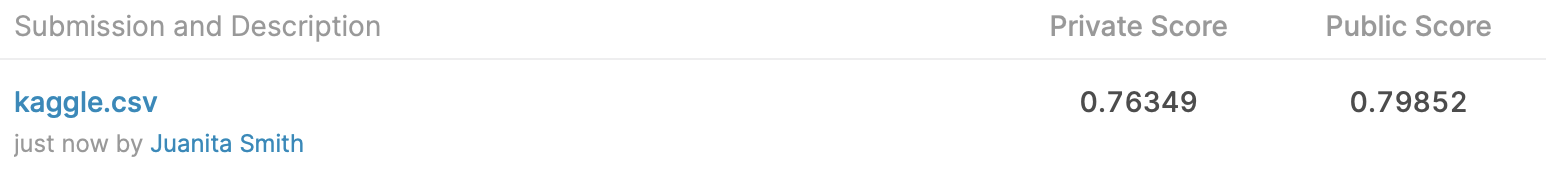

<a id='references'></a>
# References

Imbalanced datasets: 
- https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100
- https://towardsdatascience.com/classification-framework-for-imbalanced-data-9a7961354033
- https://imbalanced-learn.org/stable/references/over_sampling.html#smote-algorithms
- https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
- https://medium.com/analytics-vidhya/how-to-handle-imbalanced-dataset-b3dc05b85bf9
- https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_shrinkage_effect.html


XGBoost: 
- https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4 
- https://xgboost.readthedocs.io/en/latest/python/python_intro.html#training
- https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
- https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9
- https://discuss.xgboost.ai/t/feature-weights-does-not-work-as-expected/1998/4

Feature Selection:
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f


Evaluation Metrics:
- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
- https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781838555078/6/ch06lvl1sec34/confusion-matrix

Imputing missing values
- https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

AWS and Sagemaker
- https://aws-ml-blog.s3.amazonaws.com/artifacts/prevent-customer-churn/part_2_preventing_customer_churn_XGBoost.html
- https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-training-xgboost-report.html
